In [17]:
import torch
from datasets import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

BATCH_SIZE = 128
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

from config import load_config, get_model_name
config = load_config("vq_vae")

model_name = get_model_name(config)

sample = next(iter(train_loader))[0]

print(sample.min(), sample.max())

from models import VQVAE

model = VQVAE(128, 16)

randn = torch.randn((32, 1, 28, 28))
print("Input shape:", randn.shape)

output = model(randn)

print("Output shape:", randn.shape)



tensor(-0.5000) tensor(0.5000)
Input shape: torch.Size([32, 1, 28, 28])
Output shape: torch.Size([32, 1, 28, 28])


In [18]:
from models import VQVAE
import pytorch_lightning as pl
from trainers import BaseModule

class VAETrainer(BaseModule):
    def __init__(self, num_embeddings, embedding_dim):
        model = VQVAE(num_embeddings, embedding_dim)
        super(VAETrainer, self).__init__(model)
        self.save_hyperparameters()
        
    def forward(self, x, x_cond, y):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, quantized, latent, embedding_indices = self(x, x_cond, y)
        loss = self.model.loss(latent, quantized, x_hat, x)
        self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True, prog_bar=True)
        return loss['loss']
    
    def decode(self, z):
        return self.model.decode(z)
    
    def load_model_checkpoint(model_name):
        path = ('checkpoints/' + model_name + '.ckpt')
        return VAETrainer.load_from_checkpoint(path)
    

In [19]:
model = VAETrainer(**config['model_params'])

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
You are using a CUDA device ('A100-S

Epoch 29: 100%|██████████| 469/469 [00:05<00:00, 81.29it/s, v_num=23, train_loss=0.418, train_recon_loss=0.0877, train_vq_loss=0.165, train_commitment_loss=0.110, train_embeddding_loss=0.110, val_loss=0.422, val_recon_loss=0.0901, val_vq_loss=0.166, val_commitment_loss=0.111, val_embeddding_loss=0.111]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 469/469 [00:05<00:00, 81.26it/s, v_num=23, train_loss=0.418, train_recon_loss=0.0877, train_vq_loss=0.165, train_commitment_loss=0.110, train_embeddding_loss=0.110, val_loss=0.422, val_recon_loss=0.0901, val_vq_loss=0.166, val_commitment_loss=0.111, val_embeddding_loss=0.111]


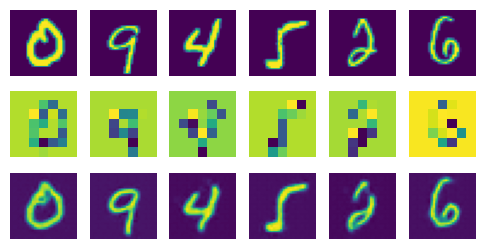

In [20]:
model = VAETrainer.load_model_checkpoint(model_name)

from plotting import plot_samples_with_reconstruction_and_indices
plot_samples_with_reconstruction_and_indices(model, next(iter(test_loader)))

In [21]:
from models.autoregresive import PixelCNN
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

pixel_cnn_model_name = "pixel_cnn_" + model_name

class PixelCNNTrainer(BaseModule):
    def __init__(self, vae_name):

        # vae does not require to be trained and saved
        vae = VAETrainer.load_model_checkpoint(vae_name)
        vae.freeze()
        vae.eval()

        model = PixelCNN(output_channels= vae.model.num_embeddings)
        super(PixelCNNTrainer, self).__init__(model)
        self.vae = vae
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, quantized, latent, embedding_indices= self.vae(x, x_cond, y)
        
        # reshape back embedding indices and detach from graph
        embedding_indices = embedding_indices.reshape(shape=(latent.shape[0], 1, latent.shape[2], latent.shape[3]))
        target = Variable(embedding_indices[:,0,:,:]).long() 

        logits = self(embedding_indices.float())

        loss = self.criterion(logits, target)
        self.log(f"{mode}_loss", loss)
        return loss

    def load_model_checkpoint(model_name, vae_name):
        path = ('checkpoints/' + model_name + '.ckpt')
        return PixelCNNTrainer.load_from_checkpoint(path, vae_name = vae_name, map_location = 'cpu')
    

In [22]:
model = PixelCNNTrainer(vae_name=model_name)

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name = pixel_cnn_model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | PixelCNN         | 2.8 M 
1 | vae       | VAETrainer       | 47.9 K
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.4 M     Trainable params
1.5 M     Non-trainable params
2.9 M     Total params
11.493    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 29: 100%|██████████| 469/469 [00:06<00:00, 72.34it/s, v_num=4]       

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 469/469 [00:06<00:00, 72.32it/s, v_num=4]


torch.Size([100, 7, 7])
torch.Size([100, 7, 7, 16])


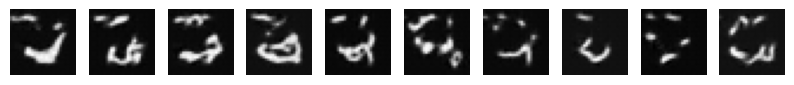

In [24]:
model = PixelCNNTrainer.load_model_checkpoint(pixel_cnn_model_name, vae_name = model_name)

def generate_and_plot(model, count):
    vae = model.vae
    sample = torch.Tensor(count, 1, 7, 7)
    sample.fill_(0)
    #Generating images pixel by pixel
    for i in range(7):
        for j in range(7):
            out = model(sample)
            probs = F.softmax(out[:,:,i,j], dim=-1).data
            sample[:,:,i,j] = torch.multinomial(probs, 1).long()
    # plot the images
    plt.figure(figsize=(10, 10))
    #test = sample.view(-1)
    test = sample.long()

    # from {B, 1, 7, 7}
    # {B 7, 7}
    test = test.squeeze(1)


    print(test.shape)
    
    x_hat = vae.model.reconstruct_from_indices(test, 100)


    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(x_hat[i,0,:,:].detach().numpy(), cmap='gray')
        plt.axis('off')

generate_and_plot(model, count=100)
